In [1]:
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM, Bidirectional
from keras.callbacks import History

Using TensorFlow backend.


The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

It must specify 3 arguments:

* **input_dim**: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
* **output_dim**: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
* **input_length**: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

# Zad. 
Podążamy za stroną: 

https://keras.io/examples/pretrained_word_embeddings/

mamy jakiś zbiór tekstów:

In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='train',categories=['sci.crypt', 'sci.electronics'])

In [3]:
# newsgroups_train.data[0]
print(newsgroups.data[0])

From: tedwards@eng.umd.edu (Thomas Grant Edwards)
Subject: Re: Once tapped, your code is no good any more.
Organization: Project GLUE, University of Maryland, College Park
Lines: 25
Distribution: na
NNTP-Posting-Host: pipa.src.umd.edu

In article <1r1r3nINNebn@dns1.NMSU.Edu> amolitor@nmsu.edu (Andrew Molitor) writes:
>In article <C5so84.Hxv@demon.co.uk> Graham Toal <gtoal@gtoal.com> writes:
>>Actually, I am *completely* baffled by why Dorothy Denning has chosen
>>to throw away her academic respectability like this.

>	Actually, I've been following her remarks for some time, with
>interest. I'm also a member of academia, and her remarks have nothing
>but elevate her respectability in my eyes. It remains to be seen whether
>you are the radical fringe, or I.

>	It is generally an error to assume that your beliefs are held by
>the majority, or even a sizable minority. Especially when you're seeing
>tens, nay dozens, of people on usenet agreeing with you.

The people on usenet are clearly a

In [4]:
X = newsgroups.data
y = newsgroups.target

len(X)

1186

In [5]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)
y[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [6]:
import nltk
import string
import re
import pandas as pd

In [7]:
def extract_content(mail):    
    # wyciagniecie tresci maila   
    return mail[mail.find("\n\n"):]

def extract_subject(mail):
    return re.findall(r'Subject:(.+)',mail)[0]


def stem_helper(word,stemmer):
    try:
        y = stemmer.stem(word)
    except:
        y = word
    return y



def clean_text(x, stemmer = nltk.PorterStemmer()):   
    """
    x - jeden mail
    """    
 
    #tokenizacja - rozbicie na liste tokenow
    x_t = nltk.word_tokenize(x)    
    # usuwanie znakow interpunkcyjnych
    translator = str.maketrans('', '', string.punctuation)
    x_t = [word.translate(translator) for word in x_t]    
    # zamina liter male
    x_t = [word.lower() for word in x_t]    
    # usuwanie zbednych tokenow
    x_t = [w for w in x_t if w not in nltk.corpus.stopwords.words("english")+["nt"]]    
    # stemming
    x_t = [stem_helper(word,stemmer) for word in x_t]    
    # sklejenie do napisu
    x_new = ' '.join(x_t)    
    return x_new


X_c = [clean_text(extract_content(x)) for x in X]
X_s = [clean_text(extract_subject(x)) for x in X]

X = pd.DataFrame({"subject":X_s, "content":X_c})

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_c,y,test_size=400)
#bierzemy tylko tresc - bez tytulu
print(y_test.shape)

(400, 2)


In [9]:
X_train[0]

'one week robot olymp game  fire mechanoid combat come  competitor pleas note slight chang  registr desk forward build scienc centr rather main compet hall  arriv  pleas go desk  preregist realmail find badg wait   see   mark tilden         glitch   mfcf hardwar design lab      u waterloo  ont   n2l3g1    519  8851211 ext  2454  opinion  hear   mine  mine  mine  mine  mine  ah hahahahahahahahaha   '

* Do warstwy **Embedding layer** wchodzi sekwencja intów.

* my wykorzystamy reprezenatację Bag of Words

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_docs = t.texts_to_sequences(X_train)
print(encoded_docs)

[[4, 519, 5253, 8008, 863, 463, 8009, 5254, 133, 2506, 153, 148, 2791, 198, 1545, 2792, 1467, 210, 596, 3152, 195, 403, 1143, 2507, 2793, 153, 65, 2792, 5255, 8010, 83, 8011, 1342, 64, 625, 8012, 4231, 8013, 278, 105, 864, 541, 4232, 8014, 8015, 4233, 8016, 3153, 8017, 261, 636, 637, 637, 637, 637, 637, 2110, 8018], [1546, 1719, 1233, 1547, 7, 176, 218, 278, 911, 22, 53, 145, 551, 2794, 46, 638, 159, 41, 370, 56, 738, 3, 3154, 43, 994, 738, 434, 1958, 2111, 911, 22, 412, 1059, 5256, 8019, 171, 384, 8020, 8021, 427, 1029, 890, 801, 5256, 707, 115, 32, 756, 435, 122, 323, 3595, 278, 70, 4234, 1059, 255, 8022, 8023, 4, 149, 385, 757, 206, 891, 8024, 27, 1548, 833, 1059, 739, 581, 26, 3596, 22, 739, 8025, 20, 2795, 116, 1059, 8026, 244, 22, 183, 167, 1959, 1059, 82, 5257, 31, 255, 4234, 41, 8027, 479, 758, 758, 8028, 5258, 8029, 8030, 34, 1406, 864, 140, 5259, 8031, 8032, 5260], [2796, 4235, 1720, 2796, 7, 115, 9, 310, 4236, 5, 80, 3, 508, 498, 17, 92, 488, 509, 118, 386, 1633, 453, 317, 3

Sekwencje mają różne długości, a Keras wymaga aby wejścia były równej długość.

In [11]:
from keras.preprocessing.sequence import pad_sequences
# pad documents to a max length of 4 words
max_length = 100
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[    4   519  5253 ...     0     0     0]
 [   53   145   551 ...  8031  8032  5260]
 [  329   802   469 ...  8039  1961  4238]
 ...
 [ 1311  1854   971 ...     0     0     0]
 [  827 14434  1177 ...   411  1937  6647]
 [ 2407  3839  2407 ...     0     0     0]]


* Embeding ma zakres 100 i długość wejściową 20. Zmniejszmy embending do wymiaru 20.
* Model jest prostym klasyfikatorem binarnym. 
* Co ważne, wynik z warstwy Embeding będzie wynosił 4 wektory o 8 wymiarach każdy, po jednym dla każdego słowa. 
* Spłaszczamy to do jednego 32-elementowego wektora, aby przejść do warstwy wyjściowej Dense.

In [12]:
history_1 = History()
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           723000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10002     
Total params: 733,002
Trainable params: 733,002
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
model.compile(loss="categorical_crossentropy",optimizer="adam", metrics=["accuracy"])
model.fit(padded_docs, y_train, epochs=100, validation_split=0.1, callbacks=[history_1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 707 samples, validate on 79 samples
Epoch 1/100
707/707 [==============================] - 1s 1ms/step - loss: 0.6833 - accuracy: 0.6110 - val_loss: 0.6761 - val_accuracy: 0.6709
Epoch 2/100
707/707 [==============================] - 0s 544us/step - loss: 0.6042 - accuracy: 0.8402 - val_loss: 0.6447 - val_accuracy: 0.7342
Epoch 3/100
707/707 [==============================] - 0s 552us/step - loss: 0.4799 - accuracy: 0.9010 - val_loss: 0.5696 - val_accuracy: 0.7975
Epoch 4/100
707/707 [==============================] - 0s 552us/step - loss: 0.2964 - accuracy: 0.9562 - val_loss: 0.4403 - val_accuracy: 0.9241
Epoch 5/100
707/707 [==============================] - 0s 546us/step - loss: 0.1330 - accuracy: 0.9943 - val_loss: 0.3236 - val_accuracy: 0.9241
Epoch 6/100
707/707 [==============================] - 0s 537us/step - loss: 0.0580 - accuracy: 0.9958 - val_loss: 0.2601 - val_accuracy:

Epoch 53/100
707/707 [==============================] - 0s 581us/step - loss: 2.7622e-04 - accuracy: 1.0000 - val_loss: 0.1496 - val_accuracy: 0.9620
Epoch 54/100
707/707 [==============================] - 0s 550us/step - loss: 2.6522e-04 - accuracy: 1.0000 - val_loss: 0.1508 - val_accuracy: 0.9620
Epoch 55/100
707/707 [==============================] - 0s 509us/step - loss: 2.5476e-04 - accuracy: 1.0000 - val_loss: 0.1505 - val_accuracy: 0.9620
Epoch 56/100
707/707 [==============================] - 0s 528us/step - loss: 2.4606e-04 - accuracy: 1.0000 - val_loss: 0.1503 - val_accuracy: 0.9620
Epoch 57/100
707/707 [==============================] - 0s 513us/step - loss: 2.3707e-04 - accuracy: 1.0000 - val_loss: 0.1501 - val_accuracy: 0.9620
Epoch 58/100
707/707 [==============================] - 0s 505us/step - loss: 2.2934e-04 - accuracy: 1.0000 - val_loss: 0.1507 - val_accuracy: 0.9620
Epoch 59/100
707/707 [==============================] - 0s 511us/step - loss: 2.2092e-04 - accuracy:

In [14]:
# evaluate the model
padded_docs_test = pad_sequences( t.texts_to_sequences(X_test), maxlen=max_length, padding='post')
loss, accuracy = model.evaluate(padded_docs_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy))

Accuracy: 0.957500


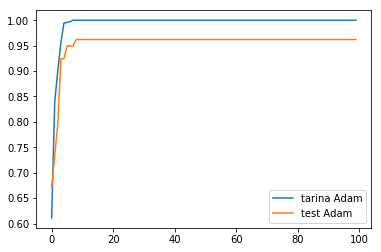

In [15]:
plt.plot(history_1.history['accuracy'], label = "tarina Adam")
plt.plot(history_1.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Pretrain embedding

https://keras.io/examples/pretrained_word_embeddings/

* GloVe embedding data can be found at: http://nlp.stanford.edu/data/glove.6B.zip (source page: http://nlp.stanford.edu/projects/glove/)

* After downloading and unzipping, you will see a few files, one of which is “glove.6B.50d.txt“, which contains a 100-dimensional version of the embedding.


Pojedyńczy plik można pobrać z tąd:
https://www.dropbox.com/sh/tjq47ybybgnrbel/AAAVbp0UkQTAbKWVMIi5mtHpa?dl=0

In [47]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B.50d')

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
# file = open(filename, encoding="utf8")
with open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'), encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs
        

print('Loaded %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Loaded 400000 word vectors.


In [48]:
embeddings_index["the"]

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

Keras provides a Tokenizer class that can be fit on the training data, can convert text to sequences consistently by calling the texts_to_sequences() method on the Tokenizer class, and provides access to the dictionary mapping of words to integers in a word_index attribute.

https://keras.io/preprocessing/text/#tokenizer

In [49]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_docs = t.texts_to_sequences(X_train)
print(encoded_docs)

[[1579, 4232, 4233, 2121, 4234, 790, 5305, 4235, 84, 173, 154, 489, 176, 763, 714, 191, 1499, 550, 1, 154, 12, 75, 97, 63, 417, 265, 619, 590, 2524, 919, 83, 714, 714, 436, 12, 97, 48, 3146, 12, 97, 89, 154, 1041, 715, 2328, 2329, 2798, 42, 2799, 1846, 460, 145, 1748, 3146, 437, 154, 63, 2525, 920, 173, 268, 156, 3, 189, 173, 71, 128, 2, 150, 16, 94, 97, 5, 551, 50, 128, 2, 156, 48, 202, 444, 69, 2800, 637, 30, 69, 2, 4236, 49, 154, 153, 196, 3147, 2330, 2331, 1252, 2526, 271, 4237, 664, 268, 53, 3, 189, 173, 94, 336, 50, 88, 50, 5, 53, 3, 189, 173, 532, 53, 1977, 49, 2, 382, 16, 1978, 743, 2122, 526, 1206, 271, 104, 562, 4238, 591, 94, 4, 50, 88, 50, 133, 53, 2, 21, 50, 3, 808, 181, 2, 665, 173, 1365, 128, 2, 3, 189, 1207, 268, 156, 1253, 5, 53, 2, 1500, 1979, 269, 203, 173, 11, 292, 128, 7993, 1979, 2527, 138, 1749, 343, 67, 592, 16, 268, 450, 213, 504, 1418, 873, 308, 1979, 128, 2, 76, 848, 5306, 679, 62, 154, 192, 438, 849, 4, 1312, 37, 952, 2123, 438, 461, 349, 451, 825, 303, 1366

Sekwencje mają różne długości, a Keras wymaga aby wejścia były równej długość.

In [50]:
from keras.preprocessing.sequence import pad_sequences
# pad documents to a max length of 4 words
max_length = 100
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[4245  157   17 ...   12   17    1]
 [4246 4247 1113 ...    0    0    0]
 [ 154  121  719 ...  100    2  232]
 ...
 [4029 6878  356 ... 3087  945 4068]
 [3042 3860  667 ...  425   71  109]
 [ 802 2057 1479 ...    0    0    0]]


Next, we need to create a matrix of one embedding for each word in the training dataset. We can do that by enumerating all unique words in the Tokenizer.word_index and locating the embedding weight vector from the loaded GloVe embedding.

The result is a matrix of weights only for words we will see during training.

In [51]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape        

(15300, 50)

In [52]:
embedding_matrix[1]

array([ 0.36403999, -0.16619   ,  0.28584   , -0.17042001, -0.42253   ,
        0.43921   , -0.2348    , -0.89033997,  0.063375  ,  0.37834999,
        0.41150999,  0.72864997,  0.72612   , -0.081949  , -0.18455   ,
        0.58287001, -0.055214  ,  0.19533999, -0.022018  , -1.20550001,
        0.47209001, -0.53654999,  0.17969   ,  0.056589  , -0.19033   ,
       -1.74269998, -0.19718   , -0.44248   ,  0.85522997, -0.51624   ,
        3.74819994, -0.094815  , -1.11039996, -0.73457003,  0.36396   ,
        0.62193   ,  0.35602999,  0.14707001, -0.42021   ,  0.16993999,
        0.74747002,  0.14756   ,  0.41393   ,  0.80216998,  0.58067   ,
        0.10242   ,  0.1147    ,  0.40129   , -0.086234  ,  0.045505  ])

In [53]:
embedding_matrix[20]

array([ 0.71518999, -0.30158001,  0.067577  , -0.42129001,  0.50601   ,
       -0.63620001, -0.028551  ,  1.09300005,  0.11205   , -0.43331   ,
        0.32583001,  0.96385002,  0.34349999, -0.10083   ,  0.33621001,
        0.43507001, -0.21405999, -0.22176   ,  1.05840003, -0.53732002,
        0.80407   ,  0.53546   ,  0.20073999,  0.74239999,  0.79689002,
       -1.10580003, -0.0016224 , -0.97474003, -0.36904001, -0.53144997,
        1.20070004,  0.90419   , -1.03509998, -1.29659998, -0.15617   ,
       -0.09742   ,  0.49832001, -0.35444   , -0.18246999, -0.02909   ,
        0.35451001, -0.46230999,  0.34483999,  0.12846   ,  0.29925999,
        0.34841999, -0.43957999,  0.96047002,  0.36509001,  0.5176    ])

The key difference is that the embedding layer can be seeded with the GloVe word embedding weights. We chose the 50-dimensional version, therefore the Embedding layer must be defined with output_dim set to 50. Finally, we do not want to update the learned word weights in this model, therefore we will set the trainable attribute for the model to be False.

In [54]:
e = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=100, trainable=False)

In [62]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import History

history_2 = History()
model = Sequential()
e = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=100, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 50)           765000    
_________________________________________________________________
flatten_15 (Flatten)         (None, 5000)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 10002     
Total params: 775,002
Trainable params: 10,002
Non-trainable params: 765,000
_________________________________________________________________
None


In [63]:
model.compile(loss="categorical_crossentropy",optimizer="adam", metrics=["accuracy"])
model.fit(padded_docs, y_train, epochs=100, validation_split=0.1, callbacks=[history_2])

Train on 707 samples, validate on 79 samples
Epoch 1/100
707/707 [==============================] - 0s 623us/step - loss: 0.6239 - accuracy: 0.6577 - val_loss: 0.5671 - val_accuracy: 0.7722
Epoch 2/100
707/707 [==============================] - 0s 99us/step - loss: 0.3284 - accuracy: 0.8939 - val_loss: 0.4897 - val_accuracy: 0.7975
Epoch 3/100
707/707 [==============================] - 0s 109us/step - loss: 0.1668 - accuracy: 0.9646 - val_loss: 0.4453 - val_accuracy: 0.8101
Epoch 4/100
707/707 [==============================] - 0s 99us/step - loss: 0.1035 - accuracy: 0.9774 - val_loss: 0.4358 - val_accuracy: 0.8101
Epoch 5/100
707/707 [==============================] - 0s 105us/step - loss: 0.0758 - accuracy: 0.9915 - val_loss: 0.4238 - val_accuracy: 0.8101
Epoch 6/100
707/707 [==============================] - 0s 102us/step - loss: 0.0595 - accuracy: 0.9929 - val_loss: 0.4276 - val_accuracy: 0.8228
Epoch 7/100
707/707 [==============================] - 0s 109us/step - loss: 0.0479 - a

Epoch 57/100
707/707 [==============================] - 0s 105us/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.5349 - val_accuracy: 0.8101
Epoch 58/100
707/707 [==============================] - 0s 108us/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.5419 - val_accuracy: 0.8101
Epoch 59/100
707/707 [==============================] - 0s 100us/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.5419 - val_accuracy: 0.8101
Epoch 60/100
707/707 [==============================] - 0s 105us/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.5444 - val_accuracy: 0.8101
Epoch 61/100
707/707 [==============================] - 0s 105us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.5445 - val_accuracy: 0.8101
Epoch 62/100
707/707 [==============================] - 0s 109us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.5437 - val_accuracy: 0.8101
Epoch 63/100
707/707 [==============================] - 0s 105us/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.5461 -

In [64]:
# evaluate the model
padded_docs_test = pad_sequences( t.texts_to_sequences(X_test), maxlen=max_length, padding='post')
loss, accuracy = model.evaluate(padded_docs_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy))

Accuracy: 0.825000


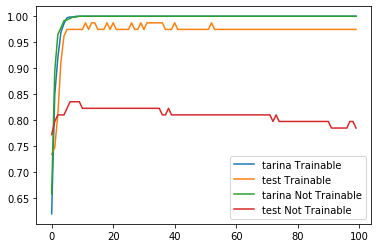

In [65]:
plt.plot(history_1.history['accuracy'], label = "tarina Trainable")
plt.plot(history_1.history['val_accuracy'], label = "test Trainable")

plt.plot(history_2.history['accuracy'], label = "tarina Not Trainable")
plt.plot(history_2.history['val_accuracy'], label = "test Not Trainable")


plt.legend()
plt.show()

In [67]:
y_train.shape

(786, 2)